Cell 1: Import necessary libraries and prepare the historical returns data

In [8]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Load combined data (adjust path if different)
combined_df = pd.read_csv("../data/combined_data.csv", index_col=0, parse_dates=True)

# Filter TSLA Close prices for training data
tsla_data = combined_df[['TSLA']].dropna()
train = tsla_data[:-126]  # assuming horizon_days=126, adjust if different

# Load scaler and LSTM model
scaler = joblib.load("../models/scaler.pkl")
lstm_model = load_model("../models/lstm_model.keras")

print("Data, scaler, and LSTM model loaded.")
print(f"Train data shape: {train.shape}")


Data, scaler, and LSTM model loaded.
Train data shape: (2409, 1)


c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# import yfinance as yf
# import pandas as pd
# import os

# tickers = ['TSLA', 'BND', 'SPY']
# start = '2015-07-01'
# end = '2025-07-31'

# all_data = {}

# for ticker in tickers:
#     print(f"Downloading {ticker}...")
#     df = yf.download(ticker, start=start, end=end, auto_adjust=True)
#     all_data[ticker] = df['Close']

# combined_df = pd.concat(all_data, axis=1)
# combined_df.columns = tickers  # Rename columns to tickers

# # Create directory if not exists
# os.makedirs("../data", exist_ok=True)

# # Save combined data
# combined_df.to_csv("../data/combined_data.csv")
# print("Combined data saved to ../data/combined_data.csv")

# combined_df.head()


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Combined data saved to ../data/combined_data.csv


,TSLA,BND,SPY
Date,,,
2015-07-01,17.943333,60.816723,174.917130
2015-07-02,18.667999,60.967087,174.756958
2015-07-06,18.648001,61.177589,174.259598
2015-07-07,17.858667,61.237740,175.355453
2015-07-08,16.997334,61.410633,172.413483


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have combined_df loaded with TSLA, BND, SPY data
# and that 'combined_df' has columns: ['TSLA', 'BND', 'SPY'] with daily prices

# Calculate daily returns for all assets
daily_returns = combined_df.pct_change().dropna()

# Annualize returns assuming 252 trading days per year
annual_returns = daily_returns.mean() * 252

# Calculate annualized covariance matrix of returns
cov_matrix = daily_returns.cov() * 252

print("Annualized Returns:")
print(annual_returns)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix)


Annualized Returns:
TSLA    0.460690
BND     0.019599
SPY     0.144844
dtype: float64

Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.350331  0.001861  0.052950
BND   0.001861  0.003016  0.001150
SPY   0.052950  0.001150  0.033272


Cell 2: Load combined data and calculate daily & annual returns

In [10]:
import pandas as pd

# Load the combined data
combined_df = pd.read_csv("../data/combined_data.csv", index_col=0, parse_dates=True)

# Calculate daily returns for all assets
daily_returns = combined_df.pct_change().dropna()

# Annualize returns assuming 252 trading days per year
annual_returns = daily_returns.mean() * 252

# Show annual returns
print("Annualized Returns:")
print(annual_returns)


Annualized Returns:
TSLA    0.460690
BND     0.019599
SPY     0.144844
dtype: float64


Cell 3: Calculate covariance matrix of daily returns and annualize it

In [11]:
# Calculate covariance matrix of daily returns
cov_matrix_daily = daily_returns.cov()

# Annualize the covariance matrix
cov_matrix_annual = cov_matrix_daily * 252

print("Annualized Covariance Matrix:")
print(cov_matrix_annual)


Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.350331  0.001861  0.052950
BND   0.001861  0.003016  0.001150
SPY   0.052950  0.001150  0.033272


Cell 4: Prepare expected returns vector including forecasted TSLA return

Here you’ll:

Calculate the expected return for TSLA based on your forecast (e.g., average daily return from the forecast)

Use historical annualized returns for BND and SPY from annual_returns

Combine into a single expected returns vector for the portfolio optimizer

In [15]:
import numpy as np
import pandas as pd

look_back = 60  # must match your LSTM input window size
horizon_days = 126  # Number of future days to forecast

# Extract the last 'look_back' values from train set, scale them
last_train_values = scaler.transform(train[-look_back:].values.reshape(-1, 1))

# Reshape to LSTM expected input shape: (1, look_back, 1)
input_seq = last_train_values.reshape(1, look_back, 1)

lstm_forecast_scaled = []

for _ in range(horizon_days):
    pred_scaled = lstm_model.predict(input_seq, verbose=0)
    lstm_forecast_scaled.append(pred_scaled[0, 0])
    
    # Slide the window by removing the oldest and adding the new prediction
     # Remove the extra brackets around pred_scaled to keep dims consistent
    input_seq = np.append(input_seq[:, 1:, :], pred_scaled.reshape(1, 1, 1), axis=1)


# Inverse transform to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1, 1)).flatten()

# Create a datetime index starting from the day after last train date, freq='B' for business days
lstm_forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=horizon_days, freq='B')

# Create the series
lstm_forecast_series = pd.Series(lstm_forecast, index=lstm_forecast_index)

print(lstm_forecast_series.head())


c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2025-01-29    398.091980
2025-01-30    394.261871
2025-01-31    390.235138
2025-02-03    386.043121
2025-02-04    381.722656
Freq: B, dtype: float32


In [17]:
# Save the LSTM forecast series to CSV for later use
lstm_forecast_series.to_csv("../data/lstm_forecast.csv")

print("LSTM forecast saved to ../data/lstm_forecast.csv")


LSTM forecast saved to ../data/lstm_forecast.csv


In [16]:
import numpy as np

# Calculate forecasted daily returns for TSLA from your LSTM or best model forecast
# Assuming `lstm_forecast_series` is your forecasted prices (from Task 3)
tsla_forecast_returns = lstm_forecast_series.pct_change().dropna()

# Average daily return forecast for TSLA (annualized)
tsla_expected_return = tsla_forecast_returns.mean() * 252

# Expected returns for BND and SPY (annualized)
bnd_expected_return = annual_returns['BND']
spy_expected_return = annual_returns['SPY']

# Combine expected returns into a vector
expected_returns = np.array([tsla_expected_return, bnd_expected_return, spy_expected_return])

print("Expected Returns Vector (annualized):")
print(expected_returns)


Expected Returns Vector (annualized):
[-0.74373711  0.01959938  0.14484444]


Here's the next cell to calculate the covariance matrix of the historical daily returns and annualize it:

In [18]:
# Calculate daily returns for all assets (TSLA, BND, SPY) from combined_df
daily_returns = combined_df.pct_change().dropna()

# Calculate annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

print("Annualized Covariance Matrix:")
print(cov_matrix)


Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.350331  0.001861  0.052950
BND   0.001861  0.003016  0.001150
SPY   0.052950  0.001150  0.033272


we’ll set up functions to compute portfolio performance and simulate portfolios to generate the efficient frontier.

In [19]:
import numpy as np

def portfolio_performance(weights, returns, cov_matrix):
    """
    Calculate portfolio expected return, volatility, and Sharpe ratio.
    """
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def generate_random_portfolios(num_portfolios, returns, cov_matrix):
    """
    Generate random portfolio weights and calculate their performance.
    """
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)
        weights_record.append(weights)

        ret, vol, sharpe = portfolio_performance(weights, returns, cov_matrix)
        results[0,i] = ret
        results[1,i] = vol
        results[2,i] = sharpe

    return results, weights_record


Now let’s compute the covariance matrix for your assets (TSLA, BND, SPY) based on their historical daily returns, then generate a bunch of random portfolios to plot the efficient frontier

In [20]:
# Calculate covariance matrix of daily returns and annualize it
cov_matrix = daily_returns.cov() * 252

# Generate 10,000 random portfolios
num_portfolios = 10000
results, weights_record = generate_random_portfolios(num_portfolios, expected_returns, cov_matrix)

# Extract returns, volatility, and Sharpe ratio from results
ret_arr = results[0]
vol_arr = results[1]
sharpe_arr = results[2]


helper function generate_random_portfolios to use for the above cell, then the plotting code for the efficient frontier:

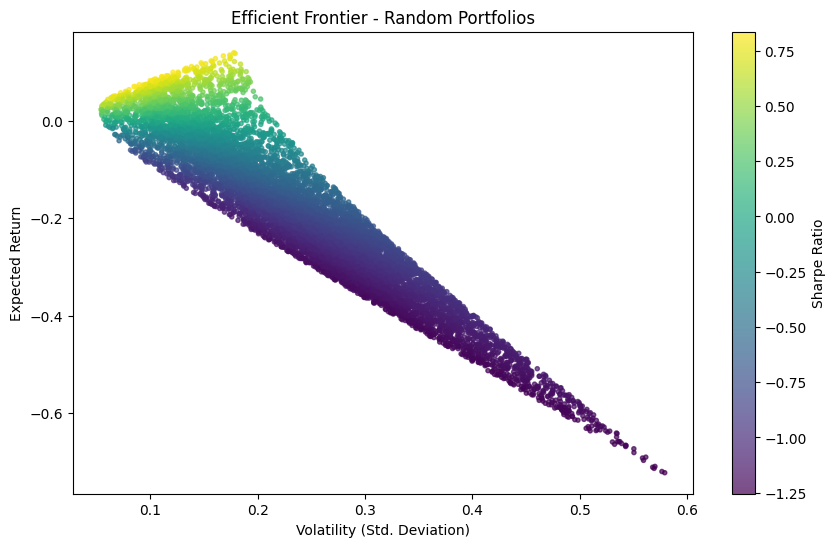

In [21]:
def generate_random_portfolios(num_portfolios, expected_returns, cov_matrix, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    num_assets = len(expected_returns)

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = sharpe_ratio

        weights_record.append(weights)

    return results, weights_record

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='.', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier - Random Portfolios')
plt.show()


Now let's find the portfolios with the maximum Sharpe ratio and minimum volatility, then mark them on the Efficient Frontier plot.

In [24]:
# Define the risk-free rate (annualized, e.g., 2%)
risk_free_rate = 0.02


In [25]:
num_portfolios = 10000
weights_arr = []
ret_arr = []
vol_arr = []
sharpe_arr = []

for _ in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    weights_arr.append(weights)
    
    portfolio_return = np.dot(weights, expected_returns)
    ret_arr.append(portfolio_return)
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    vol_arr.append(portfolio_volatility)
    
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    sharpe_arr.append(sharpe_ratio)

weights_arr = np.array(weights_arr)
ret_arr = np.array(ret_arr)
vol_arr = np.array(vol_arr)
sharpe_arr = np.array(sharpe_arr)


Max Sharpe Ratio Portfolio:
Return: 0.1280, Volatility: 0.1609, Sharpe Ratio: 0.6714
Weights: [0.00146534 0.12409852 0.87443614]

Min Volatility Portfolio:
Return: 0.0251, Volatility: 0.0540, Sharpe Ratio: 0.0950
Weights: [0.0011154  0.94789964 0.05098496]


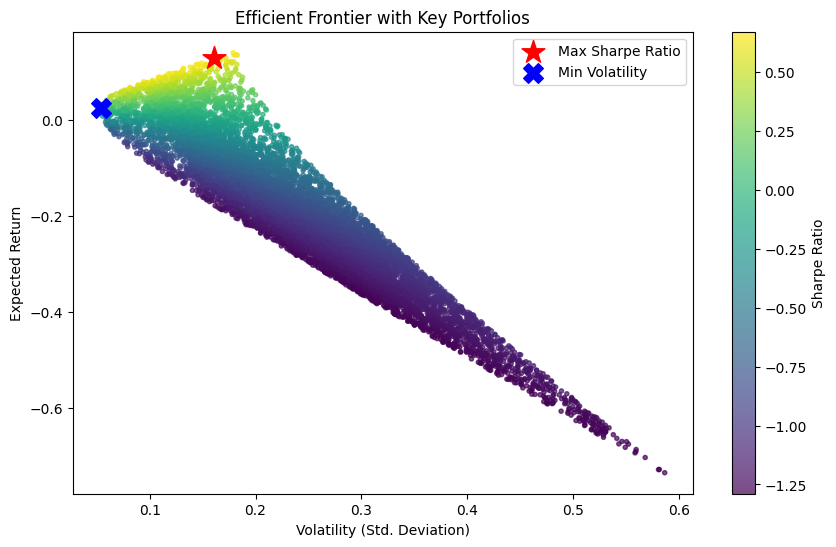

In [26]:
# Find index of max Sharpe ratio and min volatility portfolios
max_sharpe_idx = np.argmax(sharpe_arr)
min_volatility_idx = np.argmin(vol_arr)

# Portfolio weights
max_sharpe_weights = weights_arr[max_sharpe_idx]
min_volatility_weights = weights_arr[min_volatility_idx]

# Portfolio metrics
max_sharpe_return = ret_arr[max_sharpe_idx]
max_sharpe_volatility = vol_arr[max_sharpe_idx]
max_sharpe_ratio = sharpe_arr[max_sharpe_idx]

min_volatility_return = ret_arr[min_volatility_idx]
min_volatility_volatility = vol_arr[min_volatility_idx]
min_volatility_ratio = sharpe_arr[min_volatility_idx]

print("Max Sharpe Ratio Portfolio:")
print(f"Return: {max_sharpe_return:.4f}, Volatility: {max_sharpe_volatility:.4f}, Sharpe Ratio: {max_sharpe_ratio:.4f}")
print("Weights:", max_sharpe_weights)

print("\nMin Volatility Portfolio:")
print(f"Return: {min_volatility_return:.4f}, Volatility: {min_volatility_volatility:.4f}, Sharpe Ratio: {min_volatility_ratio:.4f}")
print("Weights:", min_volatility_weights)

# Plot with highlighted portfolios
plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='.', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')

# Mark max Sharpe ratio portfolio
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='r', s=300, label='Max Sharpe Ratio')

# Mark min volatility portfolio
plt.scatter(min_volatility_volatility, min_volatility_return, marker='X', color='b', s=200, label='Min Volatility')

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Key Portfolios')
plt.legend()
plt.show()


Now let's plot the Efficient Frontier along with marking the Maximum Sharpe Ratio Portfolio and the Minimum Volatility Portfolio.

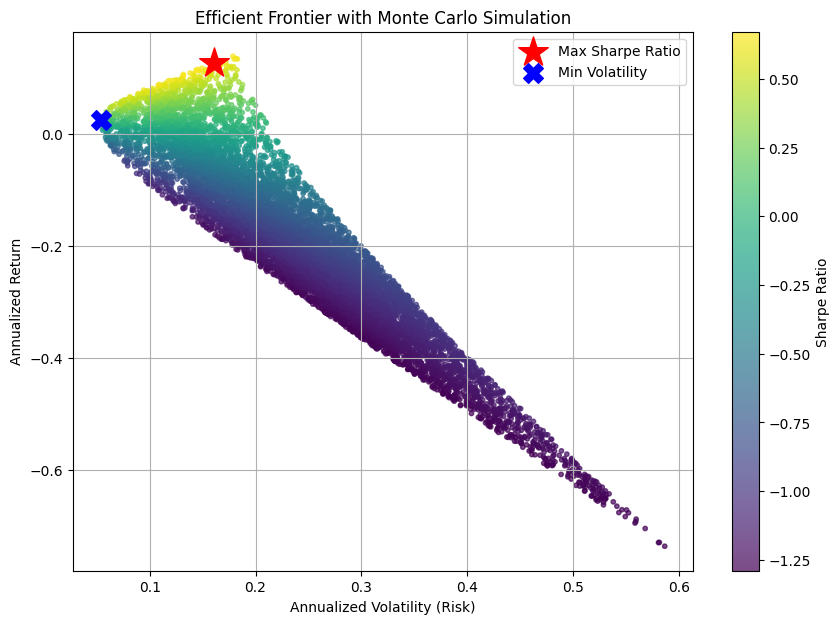

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=10, alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier with Monte Carlo Simulation')

# Mark max Sharpe Ratio portfolio
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], marker='*', color='r', s=500, label='Max Sharpe Ratio')

# Mark min volatility portfolio
plt.scatter(vol_arr[min_volatility_idx], ret_arr[min_volatility_idx], marker='X', color='b', s=200, label='Min Volatility')

plt.legend()
plt.grid(True)
plt.show()


Now let's summarize the recommended portfolio based on your analysis.

Here’s the cell to print the final recommended portfolio details:

In [28]:
print("Recommended Portfolio:")

print("\nMaximum Sharpe Ratio Portfolio:")
print(f"Weights (TSLA, BND, SPY): {max_sharpe_weights}")
print(f"Expected Annual Return: {ret_arr[max_sharpe_idx]:.4f}")
print(f"Annual Volatility: {vol_arr[max_sharpe_idx]:.4f}")
print(f"Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f"Weights (TSLA, BND, SPY): {min_volatility_weights}")
print(f"Expected Annual Return: {ret_arr[min_volatility_idx]:.4f}")
print(f"Annual Volatility: {vol_arr[min_volatility_idx]:.4f}")
print(f"Sharpe Ratio: {sharpe_arr[min_volatility_idx]:.4f}")


Recommended Portfolio:

Maximum Sharpe Ratio Portfolio:
Weights (TSLA, BND, SPY): [0.00146534 0.12409852 0.87443614]
Expected Annual Return: 0.1280
Annual Volatility: 0.1609
Sharpe Ratio: 0.6714

Minimum Volatility Portfolio:
Weights (TSLA, BND, SPY): [0.0011154  0.94789964 0.05098496]
Expected Annual Return: 0.0251
Annual Volatility: 0.0540
Sharpe Ratio: 0.0950


Finally, let's plot the efficient frontier along with the maximum Sharpe ratio and minimum volatility portfolios marked clearly.

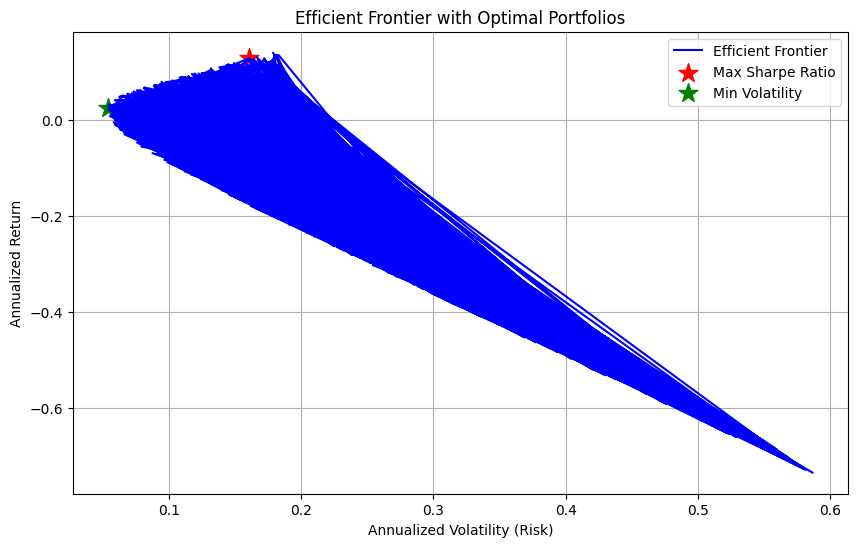

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vol_arr, ret_arr, 'b-', label='Efficient Frontier')
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], color='r', marker='*', s=200, label='Max Sharpe Ratio')
plt.scatter(vol_arr[min_volatility_idx], ret_arr[min_volatility_idx], color='g', marker='*', s=200, label='Min Volatility')

plt.title("Efficient Frontier with Optimal Portfolios")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.show()


summerize portfolio

In [30]:
print("Recommended Portfolio Based on Analysis:\n")

print(f"Maximum Sharpe Ratio Portfolio:")
print(f" - Weights: TSLA: {max_sharpe_weights[0]:.2f}, BND: {max_sharpe_weights[1]:.2f}, SPY: {max_sharpe_weights[2]:.2f}")
print(f" - Expected Annual Return: {ret_arr[max_sharpe_idx]:.2%}")
print(f" - Annual Volatility: {vol_arr[max_sharpe_idx]:.2%}")
print(f" - Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}\n")

print(f"Minimum Volatility Portfolio:")
print(f" - Weights: TSLA: {min_volatility_weights[0]:.2f}, BND: {min_volatility_weights[1]:.2f}, SPY: {min_volatility_weights[2]:.2f}")
print(f" - Expected Annual Return: {ret_arr[min_volatility_idx]:.2%}")
print(f" - Annual Volatility: {vol_arr[min_volatility_idx]:.2%}")
print(f" - Sharpe Ratio: {sharpe_arr[min_volatility_idx]:.2f}\n")


Recommended Portfolio Based on Analysis:

Maximum Sharpe Ratio Portfolio:
 - Weights: TSLA: 0.00, BND: 0.12, SPY: 0.87
 - Expected Annual Return: 12.80%
 - Annual Volatility: 16.09%
 - Sharpe Ratio: 0.67

Minimum Volatility Portfolio:
 - Weights: TSLA: 0.00, BND: 0.95, SPY: 0.05
 - Expected Annual Return: 2.51%
 - Annual Volatility: 5.40%
 - Sharpe Ratio: 0.10

